Signal 2: RSI with Bollinger Bands

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from module import *

In [7]:
tickers = ["TSLA", "AAPL", "AMD"]
start = "2020-01-01"
end = "2024-01-01"

df_prices, df_changes = download_stock_price_data(tickers, start, end)
prices = df_prices["TSLA"]

[*********************100%***********************]  3 of 3 completed


In [8]:
def compute_rsi(prices, window_length=10):
    
    prices = np.asarray(prices).flatten()
    deltas = np.diff(prices)
    
    gains = np.where(deltas > 0, deltas, 0)
    losses = np.where(deltas < 0, -deltas, 0)
    
    #Initilize and don't compute the first window_length days avg gain and loss
    avg_gain = np.empty_like(prices, dtype=float)
    avg_loss = np.empty_like(prices, dtype=float)    
    avg_gain[:window_length] = np.nan
    avg_loss[:window_length] = np.nan
    
    #First average gain and loss (simple mean)
    avg_gain[window_length] = gains[:window_length].mean()
    avg_loss[window_length] = losses[:window_length].mean()
    
    #Implement the Wilder smoothing after the first mean computation
    for i in range(window_length + 1, len(prices)):
        avg_gain[i] = (avg_gain[i - 1] * (window_length - 1) + gains[i - 1]) / window_length
        avg_loss[i] = (avg_loss[i - 1] * (window_length - 1) + losses[i - 1]) / window_length
    
    #Compute index
    rs =  avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    
    #Let the first window_length entries be nan, so it doens't generate any signal
    rsi[:window_length] = 50
    
    return rsi

def signal_rsi(prices, rsi_window, lower_rsi_bound, upper_rsi_bound):
    
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    pricnes_array = np.as_array(prices)
    rsi = compute_rsi(prices, rsi_window)
    
    buy_signal = price_array < lower_rsi_bound
    sell_signal = price_array > upper_rsi_bound

    #Create position signal with holding logic
    position = np.zeros(len(price_array), dtype=float)
    holding = 0
    for i in range(len(prices)):
        if holding == 0 and buy_signal[i]:
            holding = 1
        elif holding == 1 and sell_signal[i]:
            holding = 0
        position[i] = holding

    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals.iloc[0, signals.columns.get_loc('position_change')] = 0

    return signals['signal'], signals

In [9]:
def compute_bollinger_bands(prices, window_length=20, num_std=2):
    sma = moving_average(prices, window_length)
    
    # Calculate rolling std (using a simple moving window, numpy only)
    stds = np.empty_like(prices)
    half_w = window_length // 2
    
    for i in range(len(prices)):
        start = max(0, i - half_w)
        end = min(len(prices), i + half_w + 1)
        stds[i] = np.std(prices[start:end])
    
    upper_band = sma + num_std * stds
    lower_band = sma - num_std * stds
    
    return sma, upper_band, lower_band


def signal_bollinger(prices, bollinger_window_length=20, num_std=2, persistence=3):
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    prices_array = prices.to_numpy()
    sma, upper_band, lower_band = compute_bollinger_bands(
        prices_array, window_length=bollinger_window_length, num_std=num_std)

    # Check if prices cross back inside lower band
    outside_lower = prices_array < lower_band
    outside_lower_prev = np.roll(outside_lower, 1)
    outside_lower_prev[0] = False
    buy_signal = (outside_lower_prev == True) & (outside_lower == False)

    # Check if prices cross back inside upper band
    outside_upper = prices_array > upper_band
    outside_upper_prev = np.roll(outside_upper, 1)
    outside_upper_prev[0] = False
    sell_signal = (outside_upper_prev == False) & (outside_upper == True)

    # Initialize position logic
    position = np.zeros(len(prices_array), dtype=float)
    holding = 0
    for i in range(len(prices_array)):
        if holding == 0 and buy_signal[i]:
            holding = persistence
        if holding > 0:
            position[i] = 1.0
            holding -= 1
        if sell_signal[i]:
            holding = 0

    # Store results
    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals.loc[prices.index[0], 'position_change'] = 0

    return signals['signal'], signals


In [14]:
def combine_two_subsignals(signal1, signal2):
    
    signal1 = np.asarray(signal1)
    signal2 = np.asarray(signal2)
    assert signal1.shape == signal2.shape

    combined = np.zeros_like(signal1)
    holding = 0

    for i in range(len(signal1)):
        if holding == 0 and (signal1[i] == 1 or signal2[i] == 1):
            holding = 1
        elif holding == 1 and signal1[i] == 0 and signal2[i] == 0:
            holding = 0
        combined[i] = holding

    return combined

In [15]:
def signal02(price, rsi_window_length, lower_rsi_bound, upper_rsi_bound, bollinger_window_length, bollinger_n_stds, persistance):
    
    prices_array = price.to_numpy()

    #RSI Signal
    rsi_sig, _ = signal_rsi(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound)

    #Bollinger Signal
    bollinger_sig, _ = signal_bollinger(prices, bollinger_window_length, bollinger_n_stds, persistence=3)

    #Combine Signals
    combined = combine_two_subsignals(rsi_sig, bollinger_sig)

    #Return combined signal dataframe
    signals = pd.DataFrame(index=price.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)

    return signals

In [16]:
signals = signal02(prices, 14, 30, 70, 14, 1, 3)

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(signals)

            signal  position_change
Date                               
2020-01-02     0.0              0.0
2020-01-03     0.0              0.0
2020-01-06     0.0              0.0
2020-01-07     0.0              0.0
2020-01-08     0.0              0.0
2020-01-09     0.0              0.0
2020-01-10     0.0              0.0
2020-01-13     0.0              0.0
2020-01-14     0.0              0.0
2020-01-15     0.0              0.0
2020-01-16     0.0              0.0
2020-01-17     0.0              0.0
2020-01-21     0.0              0.0
2020-01-22     0.0              0.0
2020-01-23     0.0              0.0
2020-01-24     0.0              0.0
2020-01-27     0.0              0.0
2020-01-28     0.0              0.0
2020-01-29     0.0              0.0
2020-01-30     0.0              0.0
2020-01-31     0.0              0.0
2020-02-03     0.0              0.0
2020-02-04     0.0              0.0
2020-02-05     0.0              0.0
2020-02-06     0.0              0.0
2020-02-07     0.0          

In [5]:
# Optimize with random search
param_grid = {
    "bollinger_window_length": (10, 20),     
    "bollinger_n_stds": (1.0, 3.0),          
    "rsi_window_length": (10, 20),            
    "lower_rsi_bound": (20, 40),             
    "upper_rsi_bound": (60, 80),
    "persistance": (1, 4),                 
}



for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, best_metrics, results = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal_03, metric='cumret')
    print(ticker)
    print(best_metrics)

NameError: name 'signal_03' is not defined

In [47]:
bollinger_window_length = 14    
bollinger_n_stds = 1.5        
rsi_window_length = 14            
lower_rsi_bound = 30            
upper_rsi_bound = 70
persistance = 1    

sma, upper_band, lower_band = bollinger_bands(prices, bollinger_window_length, bollinger_n_stds)
bollinger_signals = create_bollinger_signals(prices, lower_band, upper_band, persistance)
rsi = compute_rsi(prices, rsi_window_length)
rsi_signals = create_rsi_signals(rsi, lower_rsi_bound, upper_rsi_bound)
rsi_bollinger_signals = combine_signals(rsi_signals, bollinger_signals)

#Compute measures
position = rsi_bollinger_signals
strat_returns = returns(prices, position)
cumret = cumulative_return(strat_returns)
sharpe_val = sharpe(strat_returns)

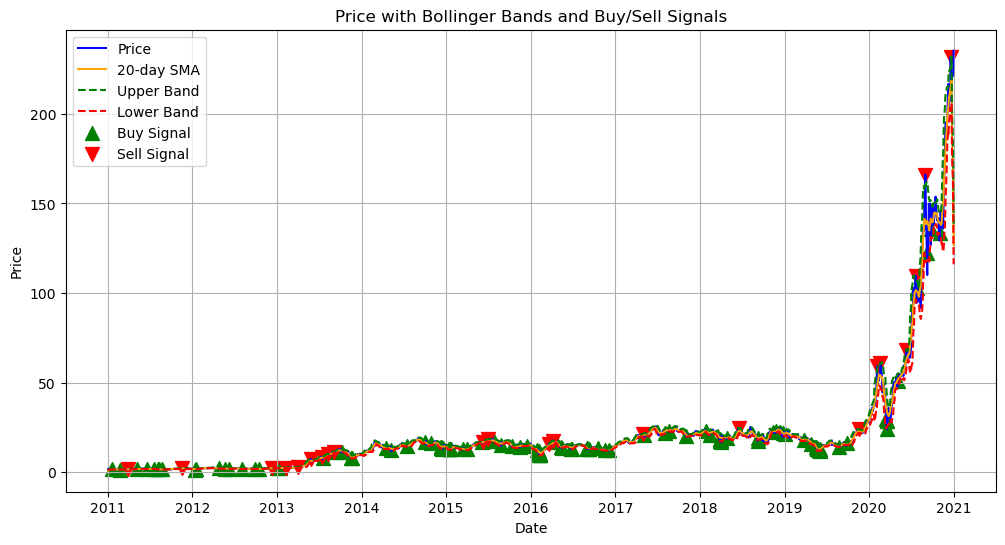

In [48]:
#Plot
sma_series = pd.Series(sma, index=prices.index)
upper_band_series = pd.Series(upper_band, index=prices.index)
lower_band_series = pd.Series(lower_band, index=prices.index)
signals_series = pd.Series(rsi_bollinger_signals, index=prices.index)

plt.figure(figsize=(12,6))
plt.plot(prices, label='Price', color='blue')
plt.plot(sma_series, label='20-day SMA', color='orange')
plt.plot(upper_band_series, label='Upper Band', color='green', linestyle='--')
plt.plot(lower_band_series, label='Lower Band', color='red', linestyle='--')

buy_points = signals_series[signals_series == 1].index
sell_points = signals_series[signals_series == -1].index
plt.scatter(buy_points, prices.loc[buy_points], marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(sell_points, prices.loc[sell_points], marker='v', color='red', label='Sell Signal', s=100)

plt.title('Price with Bollinger Bands and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()